В файле должны быть сохранены результаты запуска на тестовых данных.

Дано: API для данных о футбольных матчах и командах.

Используя kmeans сделать кластеризацию футбольных команд по среднему возрасту игроков команды и количеству проигрышей, результат отобразить в виде точечного графика для случая из 3, 4, 5 кластеров.


In [102]:
import datetime
import math
import requests
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.cluster.vq import whiten, kmeans2
from pprint import pprint

%matplotlib inline

In [103]:
def call_api(uri, result_key):
    json = {}
    try:
        json = requests.get(uri, headers={'X-Auth-Token': '156809c82dae43b2b24c75429b9140ed'}).json()
        return json[result_key]
    except:
        print('Error response:', json)
        return None

In [105]:
matches = call_api('https://api.football-data.org/v2/competitions/FL1/matches', 'matches')
print('Матчей:', len(matches))
pprint(matches[0])

Матчей: 382
{'awayTeam': {'id': 511, 'name': 'Toulouse FC'},
 'group': 'Regular Season',
 'homeTeam': {'id': 516, 'name': 'Olympique de Marseille'},
 'id': 238996,
 'lastUpdated': '2019-03-30T19:32:48Z',
 'matchday': 1,
 'referees': [{'id': 43886, 'name': 'Ruddy Buquet', 'nationality': None},
              {'id': 43915, 'name': 'Guillaume Debart', 'nationality': None},
              {'id': 15547, 'name': 'Julien Pacelli', 'nationality': None},
              {'id': 57073, 'name': 'Pignard Jérémie', 'nationality': None},
              {'id': 9374, 'name': 'Clément Turpin', 'nationality': None}],
 'score': {'duration': 'REGULAR',
           'extraTime': {'awayTeam': None, 'homeTeam': None},
           'fullTime': {'awayTeam': 0, 'homeTeam': 4},
           'halfTime': {'awayTeam': 0, 'homeTeam': 1},
           'penalties': {'awayTeam': None, 'homeTeam': None},
           'winner': 'HOME_TEAM'},
 'season': {'currentMatchday': 38,
            'endDate': '2019-05-25',
            'id': 177,
 

In [106]:
data = dict()
for match in matches:
    away_team_id = match['awayTeam']['id']
    home_team_id = match['homeTeam']['id']
    result = match['score']['winner']
    if away_team_id not in data.keys():
        data[away_team_id] = {'name': match['awayTeam']['name'], 'loses': 0, 'average_age': None}
    if home_team_id not in data.keys():
        data[home_team_id] = {'name': match['homeTeam']['name'], 'loses': 0, 'average_age': None}
    if result == 'DRAW':
        continue
    elif result == 'HOME_TEAM':
        data[away_team_id]['loses'] += 1
    elif result == 'AWAY_TEAM':
        data[home_team_id]['loses'] += 1
        
print('Команд:', len(data))
pprint(data)

Команд: 21
{511: {'average_age': None, 'loses': 16, 'name': 'Toulouse FC'},
 514: {'average_age': None, 'loses': 19, 'name': 'SM Caen'},
 516: {'average_age': None, 'loses': 13, 'name': 'Olympique de Marseille'},
 518: {'average_age': None, 'loses': 9, 'name': 'Montpellier HSC'},
 521: {'average_age': None, 'loses': 7, 'name': 'Lille OSC'},
 522: {'average_age': None, 'loses': 12, 'name': "OGC de Nice Côte d'Azur"},
 523: {'average_age': None, 'loses': 8, 'name': 'Olympique Lyonnais'},
 524: {'average_age': None, 'loses': 5, 'name': 'Paris Saint-Germain FC'},
 526: {'average_age': None, 'loses': 17, 'name': 'FC Girondins de Bordeaux'},
 527: {'average_age': None, 'loses': 10, 'name': 'AS Saint-Étienne'},
 528: {'average_age': None, 'loses': 22, 'name': "Dijon Football Côte d'Or"},
 529: {'average_age': None, 'loses': 12, 'name': 'Stade Rennais FC 1901'},
 530: {'average_age': None, 'loses': 18, 'name': 'Amiens SC'},
 532: {'average_age': None, 'loses': 12, 'name': 'Angers SCO'},
 538: 

In [107]:
players = call_api('https://api.football-data.org/v2/teams/511', 'squad')
pprint(players[:3])

[{'countryOfBirth': 'France',
  'dateOfBirth': '1991-06-03T00:00:00Z',
  'id': 8290,
  'name': 'Marc Vidal',
  'nationality': 'France',
  'position': 'Goalkeeper',
  'role': 'PLAYER',
  'shirtNumber': 16},
 {'countryOfBirth': 'Uruguay',
  'dateOfBirth': '1988-03-27T00:00:00Z',
  'id': 8291,
  'name': 'Mauro Goicoechea',
  'nationality': 'Uruguay',
  'position': 'Goalkeeper',
  'role': 'PLAYER',
  'shirtNumber': 1},
 {'countryOfBirth': 'France',
  'dateOfBirth': '1990-10-28T00:00:00Z',
  'id': 8553,
  'name': 'Baptiste Reynet',
  'nationality': 'France',
  'position': 'Goalkeeper',
  'role': 'PLAYER',
  'shirtNumber': 30}]


In [108]:
def get_age(birth_raw):
    now = datetime.datetime.today()
    birth = datetime.datetime.strptime(birth_raw, '%Y-%m-%d')
    age_raw = now - birth
    age = age_raw.days / 365
    return age

In [109]:
for team_id in data.keys():
    while not data[team_id]['average_age']:
        try:
            players = call_api(f'https://api.football-data.org/v2/teams/{team_id}', 'squad')
            age_list = []
            for player in players:
                dateOfBirth = player['dateOfBirth'].split('T')
                age = get_age(dateOfBirth[0])
                age_list.append(age)
            average_age = sum(age_list) / len(age_list)
            data[team_id]['average_age'] = average_age
        except:
            print('Waiting')
            time.sleep(60)

Error response: {'message': 'You reached your request limit. Wait 44 seconds.', 'errorCode': 429}
Waiting


In [110]:
team_for_pd = [ x for x in data.values() ]
team_for_pd

[{'average_age': 26.58506407423773, 'loses': 16, 'name': 'Toulouse FC'},
 {'average_age': 27.95264187866928,
  'loses': 13,
  'name': 'Olympique de Marseille'},
 {'average_age': 24.563810130614836, 'loses': 18, 'name': 'AS Monaco FC'},
 {'average_age': 27.49448352462051, 'loses': 16, 'name': 'FC Nantes'},
 {'average_age': 27.447193990278397,
  'loses': 22,
  'name': "Dijon Football Côte d'Or"},
 {'average_age': 27.662571807335397, 'loses': 9, 'name': 'Montpellier HSC'},
 {'average_age': 24.777064579256358,
  'loses': 12,
  'name': 'Stade Rennais FC 1901'},
 {'average_age': 26.002739726027396, 'loses': 7, 'name': 'Lille OSC'},
 {'average_age': 26.710958904109585, 'loses': 21, 'name': 'En Avant Guingamp'},
 {'average_age': 26.540239726027398, 'loses': 10, 'name': 'AS Saint-Étienne'},
 {'average_age': 27.161062681610627, 'loses': 9, 'name': 'Stade de Reims'},
 {'average_age': 24.77195385724585,
  'loses': 12,
  'name': "OGC de Nice Côte d'Azur"},
 {'average_age': 26.588184931506845, 'lose

In [111]:
teams_pd = pd.DataFrame(team_for_pd)
del teams_pd['name']
teams_pd

,average_age,loses
0,26.585064,16
1,27.952642,13
2,24.563810,18
3,27.494484,16
4,27.447194,22
5,27.662572,9
6,24.777065,12
7,26.002740,7
8,26.710959,21
9,26.540240,10


In [112]:
whitened = whiten(teams_pd.as_matrix())
whitened

array([[ 22.51366411,   2.96729955],
       [ 23.67180265,   2.41093089],
       [ 20.80195741,   3.338212  ],
       [ 23.28380948,   2.96729955],
       [ 23.24376216,   4.08003688],
       [ 23.42615569,   1.669106  ],
       [ 20.98255276,   2.22547466],
       [ 22.02052049,   1.29819355],
       [ 22.62027863,   3.89458066],
       [ 22.47570444,   1.85456222],
       [ 23.00145076,   1.669106  ],
       [ 20.97822473,   2.22547466],
       [ 22.51630702,   2.78184333],
       [ 24.42035062,   2.22547466],
       [ 23.96224398,   3.338212  ],
       [ 22.55400942,   1.48364978],
       [ 23.21075619,   2.04001844],
       [ 21.12632112,   3.15275577],
       [ 23.23051059,   3.52366822],
       [ 21.86200202,   0.92728111],
       [ 23.40339114,   0.        ]])

5 кластеров

In [113]:
centroids, cluster_map = kmeans2(whitened, 5)
centroids, cluster_map

(array([[ 22.22805909,   1.39092167],
        [ 20.972264  ,   2.73547928],
        [ 22.73351481,   3.15275577],
        [ 23.52231784,   1.669106  ],
        [ 23.47883891,   3.6473057 ]]),
 array([2, 3, 1, 2, 4, 3, 1, 0, 2, 0, 3, 1, 2, 3, 4, 0, 3, 1, 4, 0, 3]))

In [114]:
colors_map = {0: 'r', 1: 'g', 2: 'b', 3: 'y', 4: 'm'}
colors = [colors_map[c] for c in cluster_map]

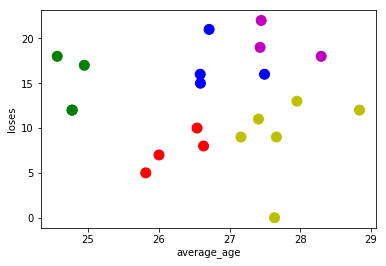

In [115]:
teams_pd.plot.scatter(x='average_age', y='loses', c=colors, s=100)

3 кластера

In [116]:
centroids, cluster_map = kmeans2(whitened, 3)
centroids, cluster_map

(array([[ 23.27363658,   3.13214953],
        [ 22.74424877,   1.36773964],
        [ 20.972264  ,   2.73547928]]),
 array([0, 0, 2, 0, 0, 1, 2, 1, 0, 1, 1, 2, 0, 0, 0, 1, 1, 2, 0, 1, 1]))

In [117]:
colors_map = {0: 'r', 1: 'g', 2: 'b'}
colors = [colors_map[c] for c in cluster_map]

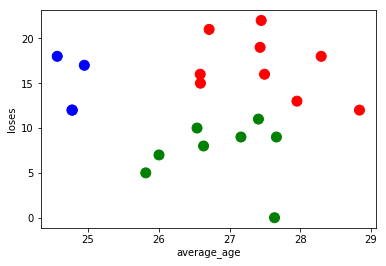

In [118]:
teams_pd.plot.scatter(x='average_age', y='loses', c=colors, s=100)

4 кластера

In [119]:
centroids, cluster_map = kmeans2(whitened, 4)
centroids, cluster_map

(array([[ 20.972264  ,   2.73547928],
        [ 23.29183511,   2.43742463],
        [ 22.55284638,   1.20546544],
        [ 23.26419884,   3.70912444]]),
 array([1, 1, 0, 1, 3, 1, 0, 2, 3, 2, 2, 0, 1, 1, 3, 2, 1, 0, 3, 2, 2]))

In [120]:
colors_map = {0: 'r', 1: 'g', 2: 'b', 3: 'y'}
colors = [colors_map[c] for c in cluster_map]

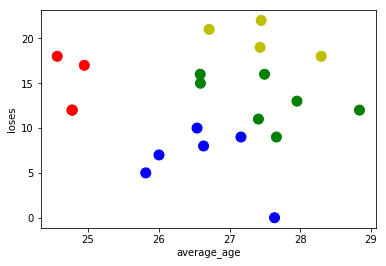

In [121]:
teams_pd.plot.scatter(x='average_age', y='loses', c=colors, s=100)